# Transfer Learning with TensorFlow Part 3: Scaling Up (Food Vision Mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food)

Our goal is to beat the original Food101 paper with 10% of the training data. (Leverage the power of deep learning)

https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline is to beat 50.76% accuracy across 101 food classes.

In [1]:
!nvidia-smi

Mon Jun  7 23:14:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them:

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-07 23:14:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-07 23:14:01 (76.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

our goal is to beat the original Food101 paper with 10% of the training data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2021-06-07 23:14:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 172.217.2.112, 172.217.164.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   136MB/s    in 12s     

2021-06-07 23:14:14 (134 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [6]:
# How many files?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/nachos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_dog'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/frozen_yogurt'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '101_food_classes_10_

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
print("Loading training data...")
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
print("Loading test data...")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Loading training data...
Found 7575 files belonging to 101 classes.
Loading test data...
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [8]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True)

In [9]:
# Create a data augmentation layer right into the model - this way we can benefit from the GPU acceleration since we have so many classes
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # if using a model that doesn't have scaling built in, you can do the following
  # preprocessing.Rescaling(1/255.)
], name="data_augmentation_layer")

In [10]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # we don't want the top layers
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # this will put the base model in inference mode (so weights which need to stay frozen, stay frozen)
x = layers.GlobalAveragePooling2D(name="global_average_pool_layer_2D")(x)
outputs = layers.Dense(101, activation="softmax", name="output_layer_softmax")(x)
model = tf.keras.Model(inputs, outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [11]:
# Get a summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pool_layer_2D (None, 1280)              0         
_________________________________________________________________
output_layer_softmax (Dense) (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [12]:
# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [13]:
# Fit to training data
model_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                         epochs=5,
                                         steps_per_epoch=len(train_data_all_10_percent),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 120s 359ms/step - loss: 3.4703 - accuracy: 0.2479 - val_loss: 2.6603 - val_accuracy: 0.3949
Epoch 2/5
237/237 [==============================] - 72s 304ms/step - loss: 2.3518 - accuracy: 0.4587 - val_loss: 2.2353 - val_accuracy: 0.4494
Epoch 3/5
237/237 [==============================] - 62s 263ms/step - loss: 1.9813 - accuracy: 0.5328 - val_loss: 2.0501 - val_accuracy: 0.4756
Epoch 4/5
237/237 [==============================] - 61s 257ms/step - loss: 1.7591 - accuracy: 0.5764 - val_loss: 2.0018 - val_accuracy: 0.4897
Epoch 5/5
237/237 [==============================] - 58s 242ms/step - loss: 1.5975 - accuracy: 0.6145 - val_loss: 1.9470 - val_accuracy: 0.4971


In [14]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 87s 110ms/step - loss: 1.7180 - accuracy: 0.5519


[1.7180315256118774, 0.5519207715988159]

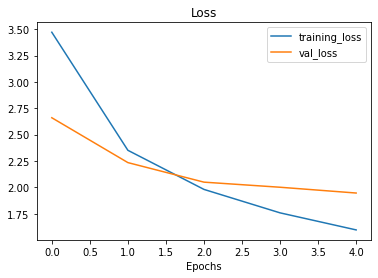

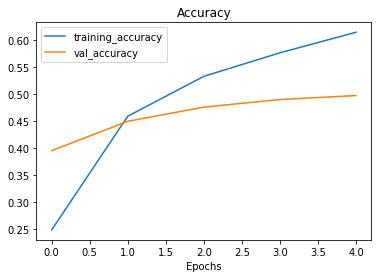

In [15]:
plot_loss_curves(model_all_classes_10_percent)

### **Overfitting SPOTTED**

This means that the model is learning patterns in the training data too well (think of you just memorizing bullet points in a notebook but not understanding the concepts) - it's not generalizing well. Let's try some fine-tuning.

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = False

# Refreeze every layer except the last 5 (this is arbitrary - this is just what is being chosen for this experiment)
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [18]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 False
global_average_pool_layer_2D True
output_layer_softmax True


In [19]:
# Check which layers are trainable in the base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [20]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=model_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 61s 239ms/step - loss: 1.4351 - accuracy: 0.6572 - val_loss: 1.9123 - val_accuracy: 0.5040
Epoch 6/10
237/237 [==============================] - 53s 222ms/step - loss: 1.4210 - accuracy: 0.6636 - val_loss: 1.9132 - val_accuracy: 0.5026
Epoch 7/10
237/237 [==============================] - 54s 226ms/step - loss: 1.3952 - accuracy: 0.6693 - val_loss: 1.9021 - val_accuracy: 0.5069
Epoch 8/10
237/237 [==============================] - 49s 205ms/step - loss: 1.3896 - accuracy: 0.6701 - val_loss: 1.8985 - val_accuracy: 0.5058
Epoch 9/10
237/237 [==============================] - 51s 212ms/step - loss: 1.3802 - accuracy: 0.6694 - val_loss: 1.9005 - val_accuracy: 0.5056
Epoch 10/10
237/237 [==============================] - 49s 205ms/step - loss: 1.3512 - accuracy: 0.6853 - val_loss: 1.8895 - val_accuracy: 0.5072


In [21]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 87s 110ms/step - loss: 1.6690 - accuracy: 0.5639


[1.6690105199813843, 0.5638811588287354]

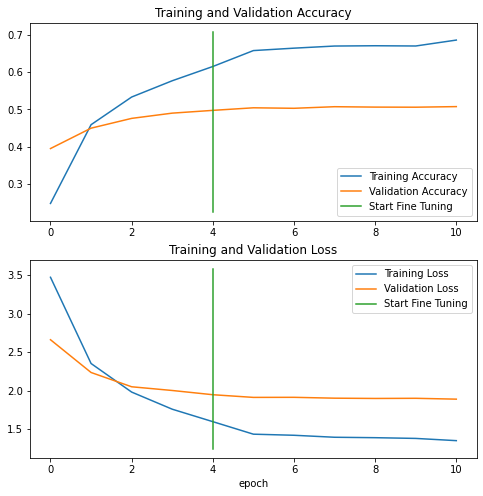

In [22]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=model_all_classes_10_percent, new_history=history_all_classes_10_percent_fine_tune, initial_epochs=5)

## Saving and loading our model
To use our model in an external application, we'll need to save it and export it

In [23]:
# Save fine-tuning model
model.save("drive/MyDrive/Colab Notebooks/TensorFlow Cert Course/101_food_classes_10_percent_fine_tuned_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/TensorFlow Cert Course/101_food_classes_10_percent_fine_tuned_model/assets


In [24]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/Colab Notebooks/TensorFlow Cert Course/101_food_classes_10_percent_fine_tuned_model")

In [25]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 89s 111ms/step - loss: 1.6690 - accuracy: 0.5639


[1.6690105199813843, 0.5638811588287354]

In [26]:
all_classes_10_percent_fine_tune_results

[1.6690105199813843, 0.5638811588287354]

## Evaluating the performance of the big model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the most wrong

In [27]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-06-07 23:36:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  90.6MB/s    in 0.5s    

2021-06-07 23:36:13 (90.6 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [28]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [29]:
# Load in pretrained model (one that was prepared earlier so all predictions are similar)
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [30]:
# Evaluate loaded model (the one we just downloaded)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 91s 114ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

# Making predictions with our trained model

In [31]:
# Because we're tackling a classification problem and using the softmax activation function, the model outputs a prediction probability tensor for each prediction
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 64s 80ms/step


In [32]:
# How many predictions are there?
len(pred_probs)

25250

In [33]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [34]:
# Let's see what the first 10 predictions look like
pred_probs[:10]

array([[5.95420077e-02, 3.57419503e-06, 4.13768589e-02, ...,
        1.41386813e-09, 8.35307583e-05, 3.08974274e-03],
       [9.64016676e-01, 1.37532707e-09, 8.47805641e-04, ...,
        5.42872003e-05, 7.83623513e-12, 9.84663906e-10],
       [9.59258676e-01, 3.25335823e-05, 1.48669467e-03, ...,
        7.18913384e-07, 5.43973158e-07, 4.02759651e-05],
       ...,
       [4.73132670e-01, 1.29312355e-07, 1.48055656e-03, ...,
        5.97501639e-04, 6.69690999e-05, 2.34693434e-05],
       [4.45719399e-02, 4.72655188e-07, 1.22585356e-01, ...,
        6.34984963e-06, 7.53185031e-06, 3.67787597e-03],
       [7.24390090e-01, 1.92497107e-09, 5.23109738e-05, ...,
        1.22913450e-03, 1.57926350e-09, 9.63957209e-05]], dtype=float32)

In [35]:
pred_probs[0], len(pred_probs[0])

(array([5.9542008e-02, 3.5741950e-06, 4.1376859e-02, 1.0660556e-09,
        8.1613978e-09, 8.6639664e-09, 8.0926822e-07, 8.5652499e-07,
        1.9859017e-05, 8.0977776e-07, 3.1727747e-09, 9.8673661e-07,
        2.8532164e-04, 7.8049051e-10, 7.4230169e-04, 3.8916416e-05,
        6.4740193e-06, 2.4977280e-06, 3.7891099e-05, 2.0678388e-07,
        1.5538422e-05, 8.1506943e-07, 2.6230446e-06, 2.0010630e-07,
        8.3827456e-07, 5.4215989e-06, 3.7390860e-06, 1.3150533e-08,
        2.7761406e-03, 2.8051838e-05, 6.8562162e-10, 2.5574835e-05,
        1.6688865e-04, 7.6407297e-10, 4.0452729e-04, 1.3150634e-08,
        1.7957379e-06, 1.4448218e-06, 2.3062859e-02, 8.2466784e-07,
        8.5365781e-07, 1.7138614e-06, 7.0525107e-06, 1.8402169e-08,
        2.8553407e-07, 7.9483234e-06, 2.0681514e-06, 1.8525066e-07,
        3.3619774e-08, 3.1522498e-04, 1.0410913e-05, 8.5448539e-07,
        8.4741873e-01, 1.0555415e-05, 4.4094671e-07, 3.7404148e-05,
        3.5306231e-05, 3.2489133e-05, 6.7314817e

In [36]:
# This is a prediction probability array (Tensor)

In [37]:
# We get one prediction probability per class - in our case, there's 101 prediction probabilities
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0 is at index: {pred_probs[0].argmax()}")
print(f"Predicted class label: {test_data.class_names[pred_probs[0].argmax()]}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542008e-02 3.5741950e-06 4.1376859e-02 1.0660556e-09 8.1613978e-09
 8.6639664e-09 8.0926822e-07 8.5652499e-07 1.9859017e-05 8.0977776e-07
 3.1727747e-09 9.8673661e-07 2.8532164e-04 7.8049051e-10 7.4230169e-04
 3.8916416e-05 6.4740193e-06 2.4977280e-06 3.7891099e-05 2.0678388e-07
 1.5538422e-05 8.1506943e-07 2.6230446e-06 2.0010630e-07 8.3827456e-07
 5.4215989e-06 3.7390860e-06 1.3150533e-08 2.7761406e-03 2.8051838e-05
 6.8562162e-10 2.5574835e-05 1.6688865e-04 7.6407297e-10 4.0452729e-04
 1.3150634e-08 1.7957379e-06 1.4448218e-06 2.3062859e-02 8.2466784e-07
 8.5365781e-07 1.7138614e-06 7.0525107e-06 1.8402169e-08 2.8553407e-07
 7.9483234e-06 2.0681514e-06 1.8525066e-07 3.3619774e-08 3.1522498e-04
 1.0410913e-05 8.5448539e-07 8.4741873e-01 1.0555415e-05 4.4094671e-07
 3.7404148e-05 3.5306231e-05 3.2489133e-05 6.7314817e-05 1.2852616e-08
 2.6219660e-10 1.0318080e-05 8.5744046e-05 1.

In [38]:
test_data.class_names[52]

'gyoza'

In [39]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [40]:
# How many pred classes do we have
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions. To evaluate them, we need to compare them to the original test dataset labels

In [41]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

We gotta unbatch this to get labels

In [42]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1] - one hot encoded
  # we want the index value where the "1" occurs and we want numpy to get it into an array
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [43]:
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [44]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [45]:
# Does this metric come close to our model's evaluated results
import numpy as np

np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visualize: making a confusion matrix

In [46]:
from helper_functions import make_confusion_matrix

In [47]:
# Get a list of class names
class_names = test_data.class_names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

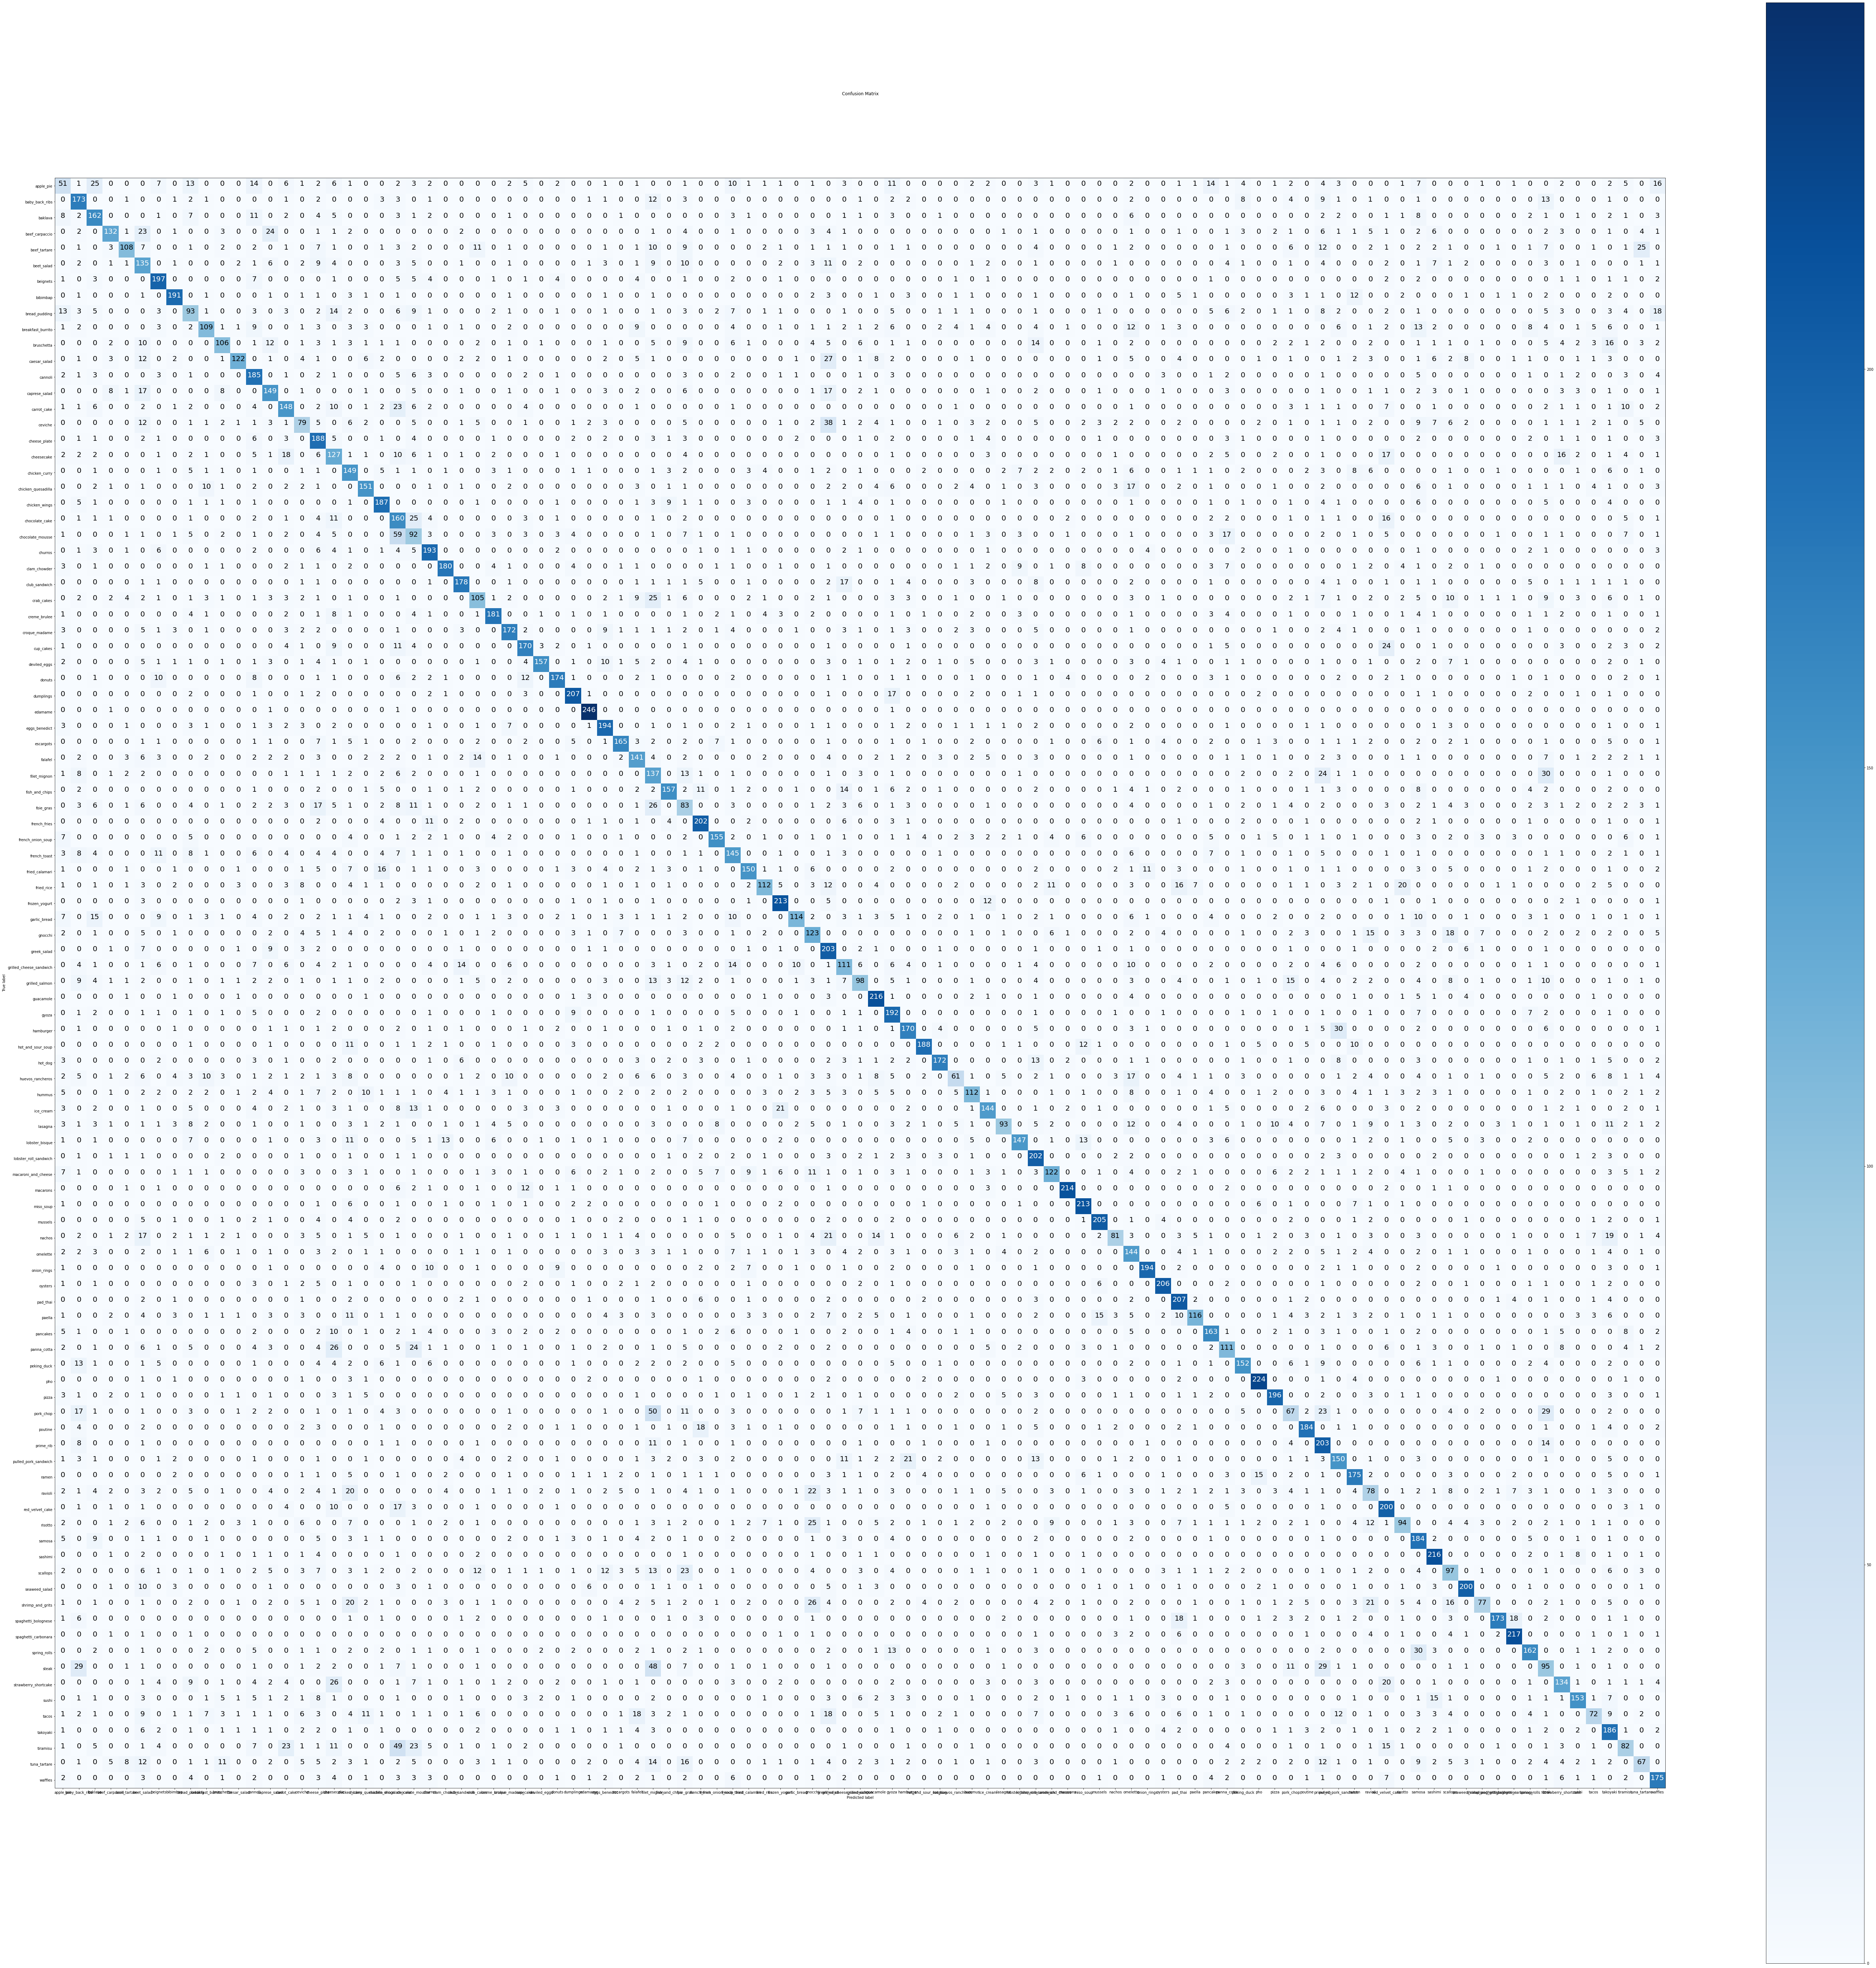

In [48]:
make_confusion_matrix(y_labels, pred_classes, class_names, figsize=(100, 100), text_size=20)

In [49]:
# We need to make some changes to the confusion matrix function to get the x axis labels vertical
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Updated here: Changing x-labels to be vertical
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

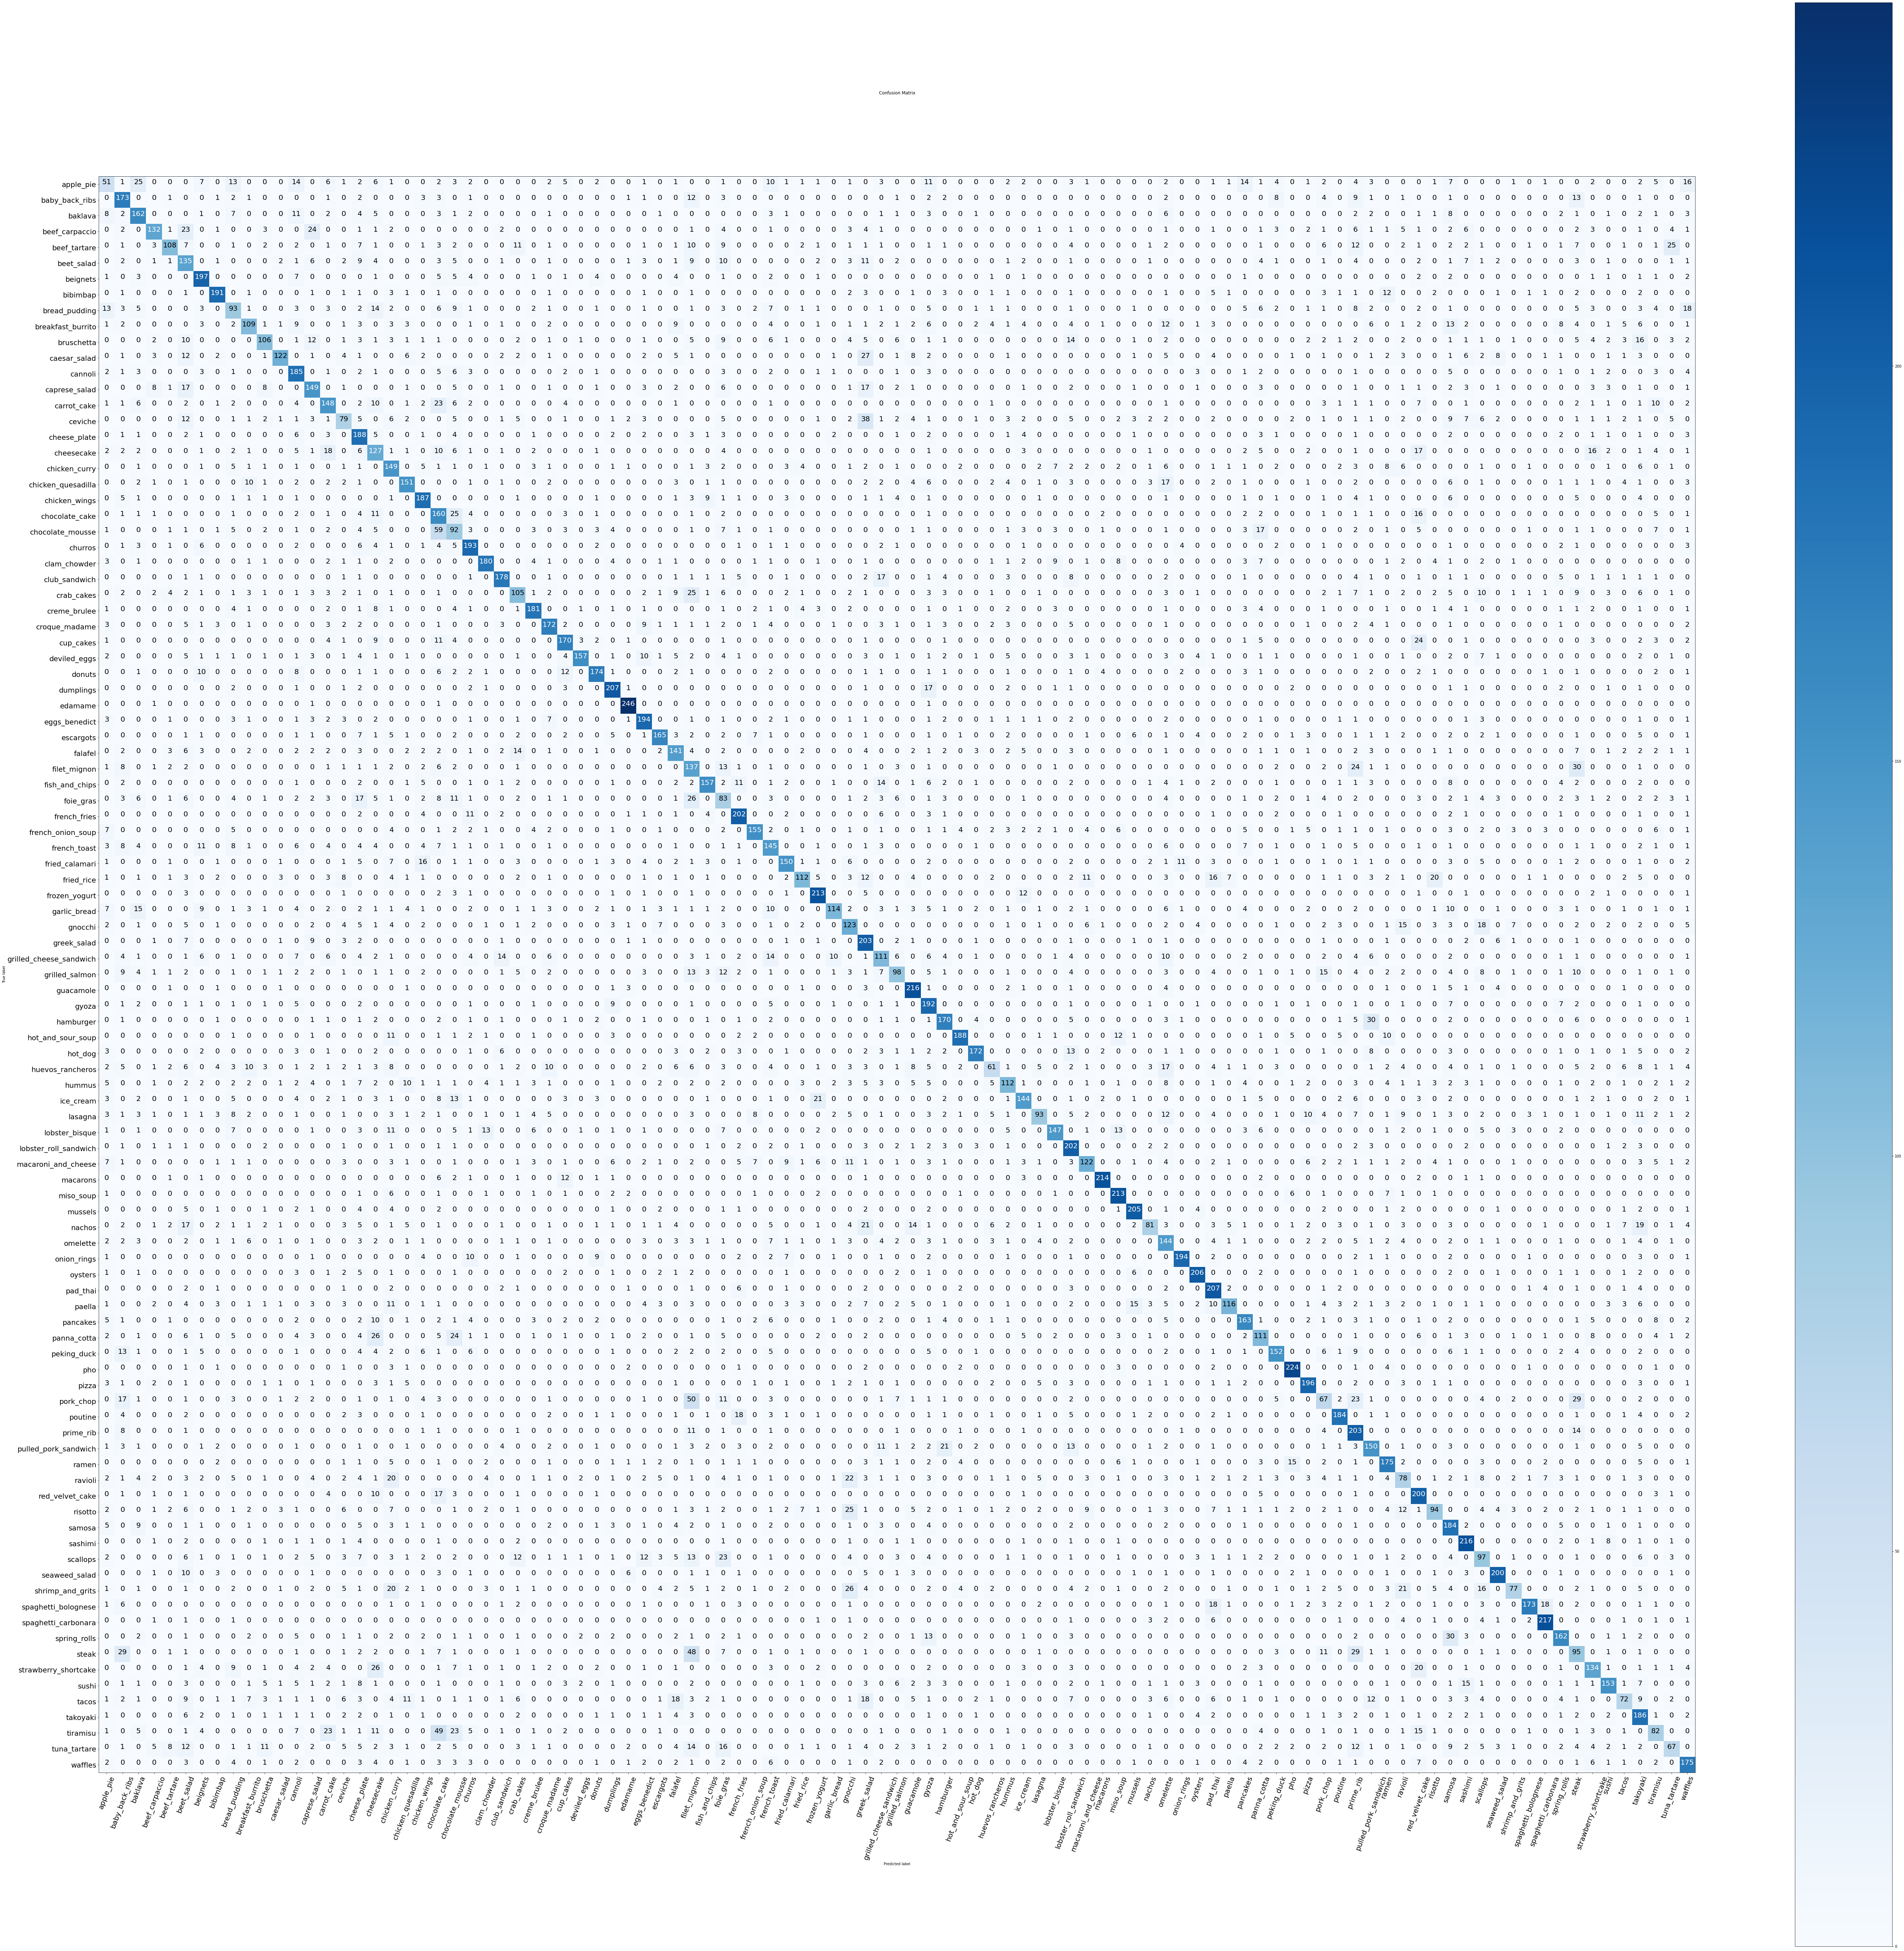

In [50]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

make_confusion_matrix(y_labels, pred_classes, class_names, figsize=(100, 100), text_size=20)

## Let's keep the evaluation train going, time for a classification report

Scikit-Learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called `classification_report`

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [52]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [53]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

Let's plot all of our classes F1-scores...

In [54]:
# Create an empty dictionary
class_f1_scores = {}

for key, value in classification_report_dict.items():
  if key == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(key)]] = value["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [55]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class names": list(class_f1_scores.keys()), "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending=False)
f1_scores

class names  f1_score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

In [56]:
f1_scores.head()

class names  f1_score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008

In [57]:
f1_scores.tail(10)

class names  f1_score
96             tacos  0.380952
15           ceviche  0.367442
99      tuna_tartare  0.353562
82           ravioli  0.342857
93             steak  0.342342
56  huevos_rancheros  0.339833
22  chocolate_mousse  0.329159
77         pork_chop  0.308756
39         foie_gras  0.297491
0          apple_pie  0.240566

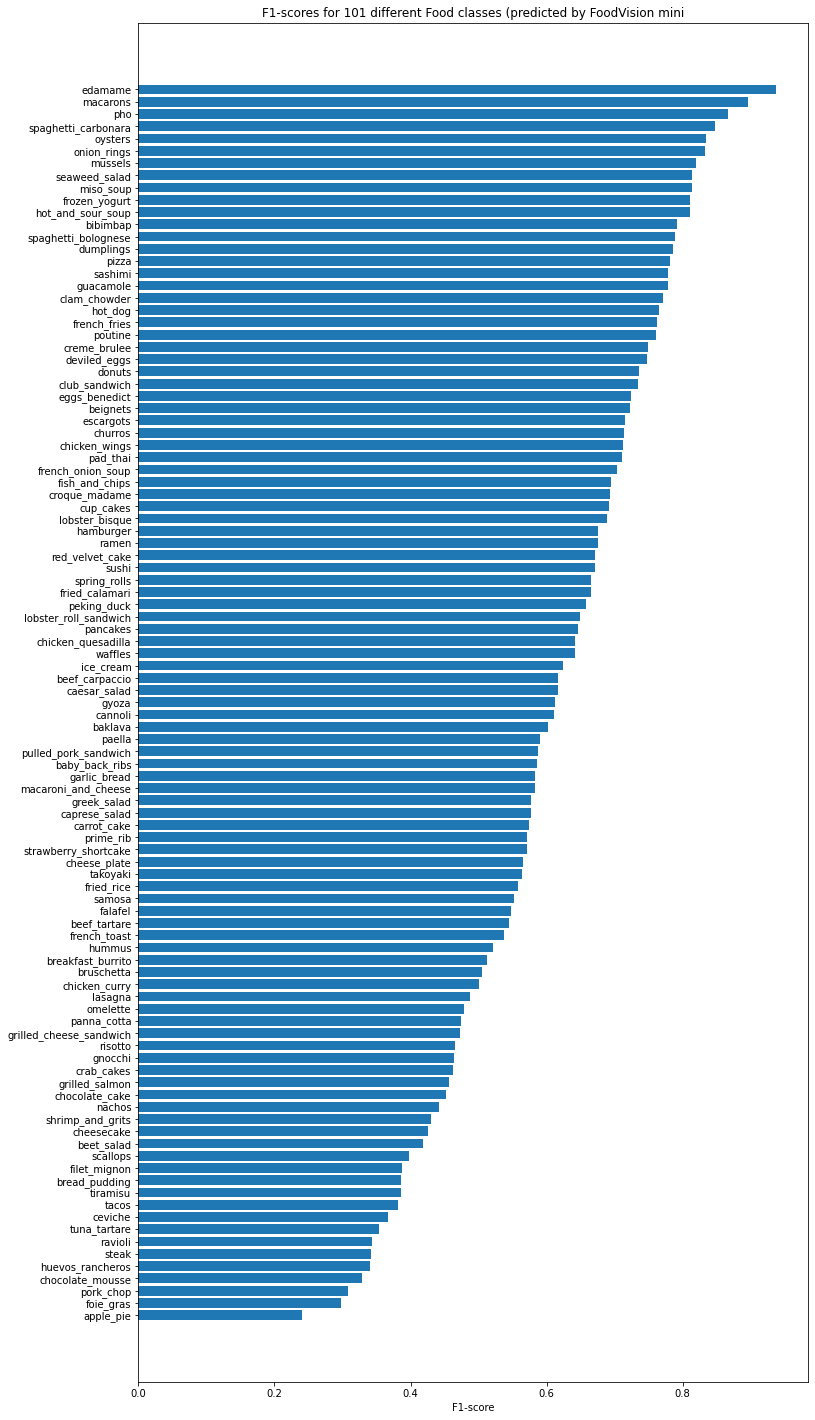

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1_score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 different Food classes (predicted by FoodVision mini")
ax.invert_yaxis();

## Visualizing predictions on custom images

* Read in a target image filepath using `tf.io.read_file()`
* Turn the image into a Tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our mdoel has trained on using `tf.image.resize()`
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [59]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into 
  specified shape (img_shape, img_shape, color_channels=3)

  Args:
    filename(str): path to target image
    image_shape(int): height/width dimension of target image size
    scale(bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read image
  img = tf.io.read_file(filename)

  # Decode the image into a tensor
  img = tf.io.decode_image(img, channels=3) # our model needs 3 channels

  # Resize
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow
  

1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along along with the model's predictions, prediction probability and ground truth label

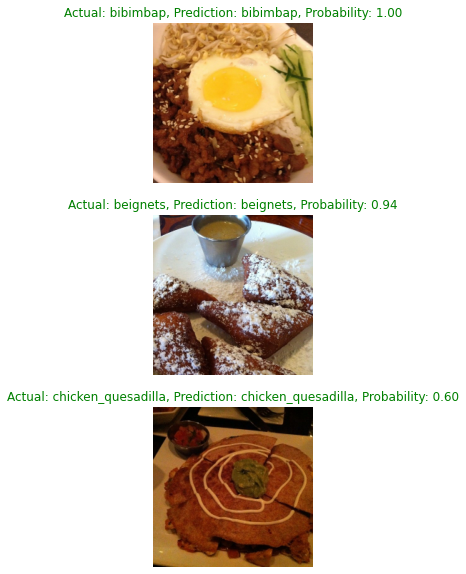

In [60]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random classes
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # get prediction prob array
  pred_class = class_names[pred_prob.argmax()] # get highest value index 

  # Plot the image(s) - 1 row, 3 columns
  plt.subplot(3, 1, i+1)
  plt.imshow(img/255.)

  # If predicted class matches truth class, make the text color green
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"Actual: {class_name}, Prediction: {pred_class}, Probability: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)


## Finding the most wrong predictions

A good way to inspect your model's performance is to view the wrong predictions with the highest prediction probability
Can reveal insights such as:
* Data issues (wrong labels)
* Confusing classes

1. Get all of the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names
3. Use our dataframe to find all of the wrong predictions ( where the ground truth label doens't match the prediction)
4. Sort the dataframe based on wrong predictions (have the highest prediction probability predictions at the top)
5. Visualize the images with the higest prediction probabilities but have the wrong prediction.

In [61]:
# Get all of the image file paths in the test dataset
filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [62]:
# Create a dataframe of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  ...      y_pred_classname
0      b'/content/101_food_classes_10_percent/test/ap...  ...                 gyoza
1      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
2      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
3      b'/content/101_food_classes_10_percent/test/ap...  ...  pulled_pork_sandwich
4      b'/content/101_food_classes_10_percent/test/ap...  ...             prime_rib
...                                                  ...  ...                   ...
25245  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25246  b'/content/101_food_classes_10_percent/test/wa...  ...          cheese_plate
25247  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25248  b'/content/101_food_classes_10_percent/test/wa...  ...  strawberry_shortcake
25249  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles

[25250 rows x 6 columns]

In [63]:
# 3. Find out in our dataframe which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  b'/content/101_food_classes_10_percent/test/ap...  ...         False
1  b'/content/101_food_classes_10_percent/test/ap...  ...          True
2  b'/content/101_food_classes_10_percent/test/ap...  ...          True
3  b'/content/101_food_classes_10_percent/test/ap...  ...         False
4  b'/content/101_food_classes_10_percent/test/ap...  ...         False

[5 rows x 7 columns]

In [64]:
# 4. Sort our DataFrame to havev most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  ...  pred_correct
21810  b'/content/101_food_classes_10_percent/test/sc...  ...         False
231    b'/content/101_food_classes_10_percent/test/ap...  ...         False
15359  b'/content/101_food_classes_10_percent/test/lo...  ...         False
23539  b'/content/101_food_classes_10_percent/test/st...  ...         False
21400  b'/content/101_food_classes_10_percent/test/sa...  ...         False
24540  b'/content/101_food_classes_10_percent/test/ti...  ...         False
2511   b'/content/101_food_classes_10_percent/test/br...  ...         False
5574   b'/content/101_food_classes_10_percent/test/ch...  ...         False
17855  b'/content/101_food_classes_10_percent/test/pa...  ...         False
23797  b'/content/101_food_classes_10_percent/test/su...  ...         False
18001  b'/content/101_food_classes_10_percent/test/pa...  ...         False
11642  b'/content/101_food_classes_10_percent/test/ga...  ...         False
10847  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23631  b'/content/101_food_classes_10_percent/test/st...  ...         False
1155   b'/content/101_food_classes_10_percent/test/be...  ...         False
10854  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23904  b'/content/101_food_classes_10_percent/test/su...  ...         False
7316   b'/content/101_food_classes_10_percent/test/cu...  ...         False
13144  b'/content/101_food_classes_10_percent/test/gy...  ...         False
10880  b'/content/101_food_classes_10_percent/test/fr...  ...         False

[20 rows x 7 columns]

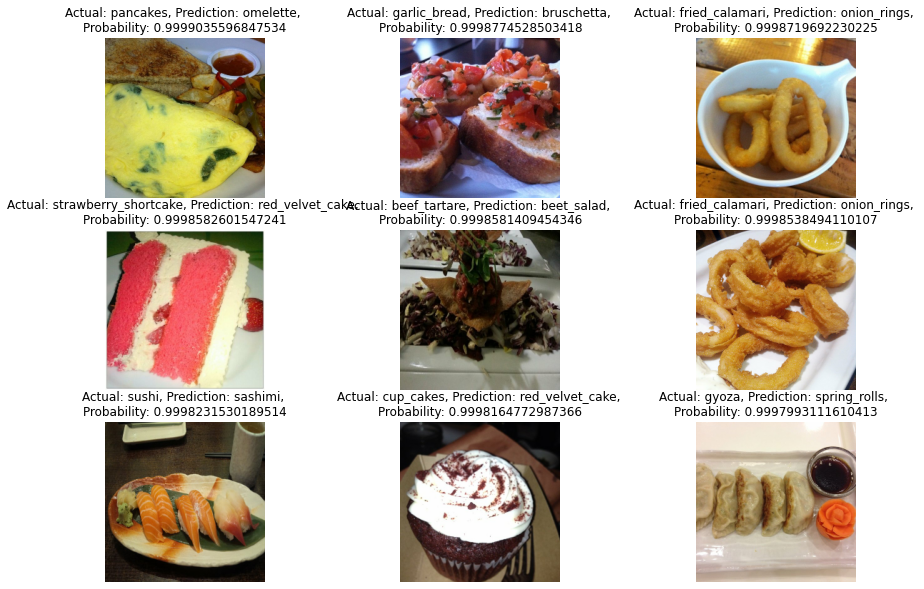

In [65]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 10
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_class_name, y_pred_classname, _ = row #only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"Actual: {y_true_class_name}, Prediction: {y_pred_classname}, \nProbability: {pred_prob}")
  plt.axis(False)


In [66]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2021-06-07 23:41:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.80, 172.253.63.128, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  39.1MB/s    in 0.3s    

2021-06-07 23:41:50 (39.1 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [69]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/ramen.jpg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/nachos.jpg',
 'custom_food_images/tacos.jpg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg']

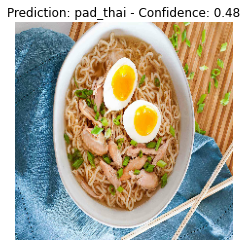

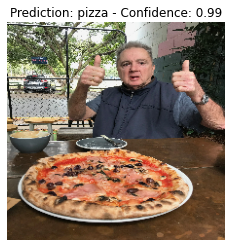

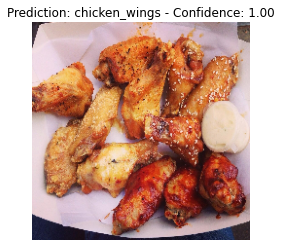

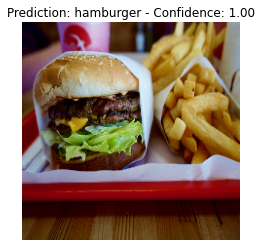

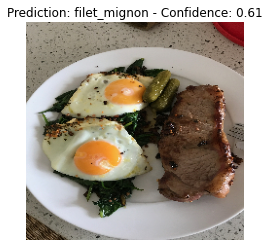

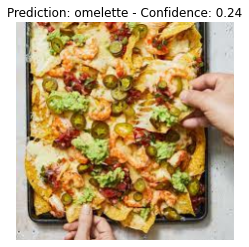

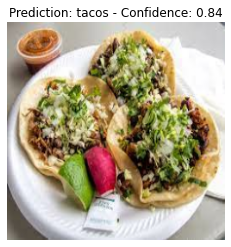

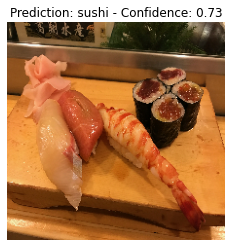

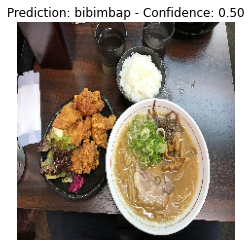

In [70]:
# Make predictions on custom images and plot them
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()] # get index with the highest prediction probability
  # Plot the appropriate function
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Prediction: {pred_class} - Confidence: {pred_prob.max():.2f}")
  plt.axis(False)

In [74]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_2D")(x)
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)
model_feature_extraction_no_fine_tuning = tf.keras.Model(inputs, outputs)

In [75]:
model_feature_extraction_no_fine_tuning.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [76]:
history_feat_extract_no_tuning = model_feature_extraction_no_fine_tuning.fit(train_data_all_10_percent, epochs=10, steps_per_epoch=len(train_data_all_10_percent), validation_data=test_data, validation_steps=int(0.15 * len(test_data)))

Epoch 1/10
237/237 [==============================] - 54s 208ms/step - loss: 3.4775 - accuracy: 0.2437 - val_loss: 2.6918 - val_accuracy: 0.3935
Epoch 2/10
237/237 [==============================] - 47s 197ms/step - loss: 2.3426 - accuracy: 0.4628 - val_loss: 2.2547 - val_accuracy: 0.4513
Epoch 3/10
237/237 [==============================] - 48s 203ms/step - loss: 1.9832 - accuracy: 0.5275 - val_loss: 2.0545 - val_accuracy: 0.4883
Epoch 4/10
237/237 [==============================] - 45s 190ms/step - loss: 1.7592 - accuracy: 0.5707 - val_loss: 2.0047 - val_accuracy: 0.4876
Epoch 5/10
237/237 [==============================] - 45s 188ms/step - loss: 1.6016 - accuracy: 0.6021 - val_loss: 1.9618 - val_accuracy: 0.4873
Epoch 6/10
237/237 [==============================] - 45s 188ms/step - loss: 1.4765 - accuracy: 0.6350 - val_loss: 1.9529 - val_accuracy: 0.4894
Epoch 7/10
237/237 [==============================] - 45s 188ms/step - loss: 1.3882 - accuracy: 0.6527 - val_loss: 1.9279 - val_ac

In [77]:
# Model with feature extraction for 5 epochs and fine tuning for 5 epochs
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [81]:
results_feat_extract_no_tuning = model_feature_extraction_no_fine_tuning.evaluate(test_data)

790/790 [==============================] - 87s 110ms/step - loss: 1.6378 - accuracy: 0.5669
